In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.cosmology import FlatLambdaCDM

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/'
filename = 'redmagic_sdss_allcolumns_pixel.csv'
data = pd.read_csv(path + filename)
data.head()

,COADD_OBJECT_ID,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,ID,PIXEL
0,188536135,317.999774,-2.047044,0.156339,0.079792,0.459138,272.88403,188536135,78250438
1,210952287,326.339041,-0.003665,0.173799,0.082191,0.447773,251.80692,210952287,78031503
2,210938821,326.570650,0.209584,0.236705,-0.187670,0.627276,304.14548,210938821,78031841
3,212176275,325.924446,-0.765189,0.110214,0.074650,0.549774,228.24649,212176275,77854818
4,307585462,38.238711,-6.155106,-0.007181,-0.041391,0.300392,265.68323,307585462,150726796


In [3]:
numpix = 46
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }
DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [4]:
Einstein = []
for index, row in data.iterrows():
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [row['Z']],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [0.9, 1.3],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': 7} 
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    kwargs_mass = [{'sigma_v': row['VEL_DISP'], 'center_x': 0, 'center_y': 0, 
                    'e1': 0, 'e2': 0}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    Einstein.append(kwargs_lens[0]['theta_E'])

In [5]:
data['THETA_E'] = Einstein
data.head()

,COADD_OBJECT_ID,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,ID,PIXEL,THETA_E
0,188536135,317.999774,-2.047044,0.156339,0.079792,0.459138,272.88403,188536135,78250438,1.711158
1,210952287,326.339041,-0.003665,0.173799,0.082191,0.447773,251.80692,210952287,78031503,1.465135
2,210938821,326.570650,0.209584,0.236705,-0.187670,0.627276,304.14548,210938821,78031841,1.959768
3,212176275,325.924446,-0.765189,0.110214,0.074650,0.549774,228.24649,212176275,77854818,1.145608
4,307585462,38.238711,-6.155106,-0.007181,-0.041391,0.300392,265.68323,307585462,150726796,1.753573


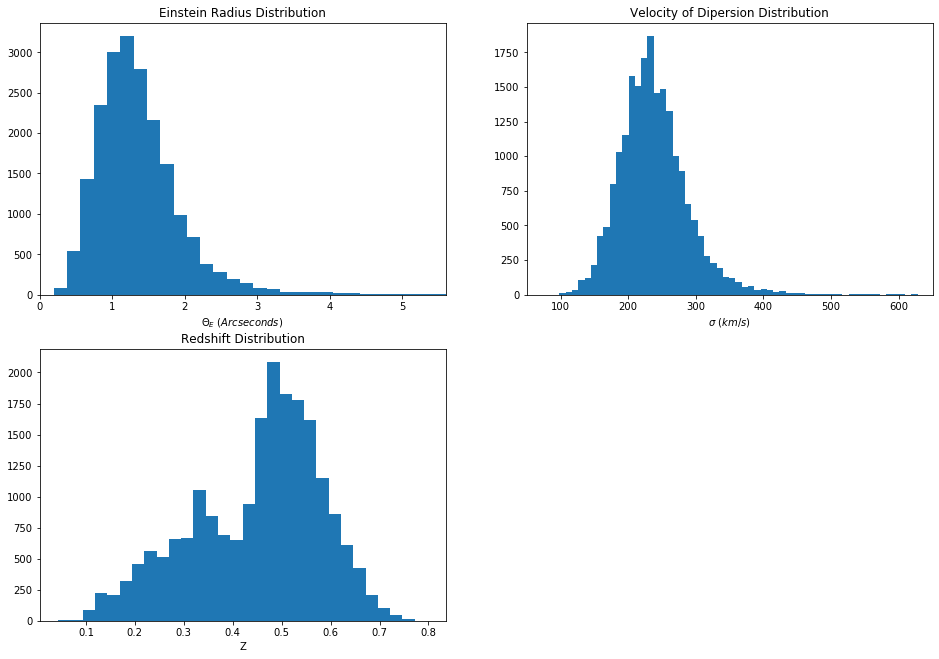

In [26]:
plt.figure(figsize=(16,11))

plt.subplot(2, 2, 1)
plt.hist(data['THETA_E'], 80)
plt.title('Einstein Radius Distribution')
plt.xlabel(r'$\Theta_E\ (Arc seconds)$')
plt.xlim(0,5.6)

plt.subplot(2, 2, 2)
plt.hist(data['VEL_DISP'], 80)
plt.title('Velocity of Dipersion Distribution')
plt.xlabel(r'$\sigma\ (km/s)$')
plt.xlim(50, 650)

plt.subplot(2, 2, 3)
plt.hist(data['Z'], 30)
plt.title('Redshift Distribution')
plt.xlabel('Z')

plt.show()

In [18]:
data_cut = data[data['THETA_E'] > 1]
print(len(data) - len(data_cut))

5540
